# Community mapping- Prediction of crops based on environmental conditions


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report,precision_score,recall_score,roc_curve
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

In [158]:
crops = pd.read_csv("vijayawada_guntur_soil_climate_data_subset.csv") 

In [159]:
crops.shape[0]

150

In [160]:
crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Latitude            150 non-null    float64
 1   Longitude           150 non-null    float64
 2   Soil_Type           150 non-null    object 
 3   Precipitation (mm)  150 non-null    int64  
 4   Temperature (Â°C)   150 non-null    float64
 5   class               150 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 7.2+ KB


In [161]:
crops.describe()

,Latitude,Longitude,Precipitation (mm),Temperature (Â°C)
count,150.000000,150.000000,150.000000,150.000000
mean,16.114753,80.517522,147.106667,30.764667
std,0.385490,0.291412,79.038955,5.254492
min,15.507179,80.005062,0.000000,22.300000
25%,15.779216,80.247478,84.500000,25.875000
50%,16.082545,80.556001,150.500000,30.600000
75%,16.474560,80.757838,215.500000,35.500000
max,16.782953,80.990054,291.000000,40.000000


List of Attributes within the dataset

In [162]:
columns = [column for column in crops]
print(columns)

['Latitude', 'Longitude', 'Soil_Type', 'Precipitation (mm)', 'Temperature (Â°C)', 'class']


Counting the number of _Potential hazardous Asteroids_ and _Near Earth Asteroids_ within the `asteroid` dataset

In [163]:
categorical=pd.DataFrame(columns=['Categorical Columns','Unique Values'])
object_columns=list(crops.columns[crops.dtypes=='O'])
for columns in object_columns:
    unique_val= crops[columns].unique()
    categorical= pd.concat([categorical, pd.DataFrame({'Categorical Columns': [columns], 'Unique Values': [unique_val]})], ignore_index=True)
categorical

,Categorical Columns,Unique Values
0,Soil_Type,"[Clay Loam, Alluvial Soil, Sandy Loam, Red Soil]"
1,class,"[Rice, Chilli, Maize, Turmeric, Sugarcane, Mil..."


In [164]:
Continuous=pd.DataFrame(columns=['Continuous Columns','Unique Values'])
nonobject_columns=list(crops.columns[crops.dtypes!='O'])
for columns in nonobject_columns:
    unique_val= crops[columns].unique()
    Continuous = pd.concat([Continuous, pd.DataFrame({'Continuous Columns': [columns], 'Unique Values': [unique_val]})], ignore_index=True)
Continuous

,Continuous Columns,Unique Values
0,Latitude,"[15.986902154501571, 16.73592859833289, 16.451..."
1,Longitude,"[80.90826588596666, 80.23956189066698, 80.1448..."
2,Precipitation (mm),"[263, 92, 89, 114, 104, 195, 113, 74, 216, 276..."
3,Temperature (Â°C),"[27.6, 36.6, 34.3, 24.9, 38.4, 36.8, 39.1, 35...."


Dropping irrelevant attribute

In [165]:
updated_crops = crops.drop(columns=["Latitude","Longitude"])

Checking for Null values

In [166]:
updated_crops.isnull().sum()

Soil_Type             0
Precipitation (mm)    0
Temperature (Â°C)     0
class                 0
dtype: int64

Creating variable _classes_ to store the orbit classes of asteroids, to be used to fill missing albedo values that dont have corressponging _H Magnitude_ or _Object Diameter_.

In [167]:
classes = list(crops["class"].unique())
classes

['Rice',
 'Chilli',
 'Maize',
 'Turmeric',
 'Sugarcane',
 'Millet',
 'Cotton',
 'Groundnut']

In [168]:
updated_crops.isnull().sum()

Soil_Type             0
Precipitation (mm)    0
Temperature (Â°C)     0
class                 0
dtype: int64

### Univariate Analysis

In [169]:
Counts = []
for i in classes:
    Counts.append(len(updated_crops[updated_crops["class"]=="{}".format(i)]))

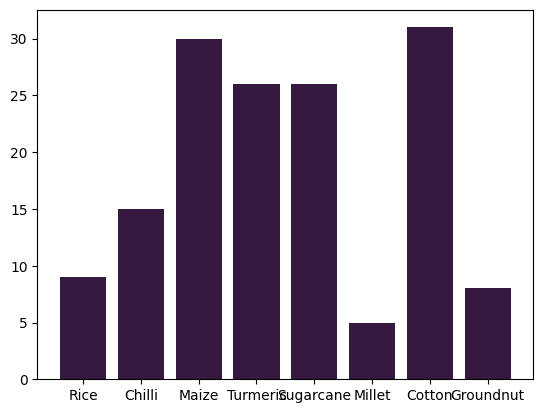

In [170]:
sns.set_palette("rocket")
plt.bar(classes,Counts)
plt.show()

In [171]:
column_classes = ["Soil_Type","Class"]

In [172]:
updated_crops.columns

Index(['Soil_Type', 'Precipitation (mm)', 'Temperature (Â°C)', 'class'], dtype='object')

#### Data Transformation

In [173]:
label_enc=LabelEncoder()
cla={}
for i in categorical.iloc[[0,1]]['Categorical Columns']:
    updated_crops[i] = label_enc.fit_transform(updated_crops[i])
    cla[f"{i}"]=label_enc.classes_
    encoding_mapping = dict(zip(label_enc.classes_, range(len(label_enc.classes_))))
    print(encoding_mapping)

{'Alluvial Soil': 0, 'Clay Loam': 1, 'Red Soil': 2, 'Sandy Loam': 3}
{'Chilli': 0, 'Cotton': 1, 'Groundnut': 2, 'Maize': 3, 'Millet': 4, 'Rice': 5, 'Sugarcane': 6, 'Turmeric': 7}


In [174]:
updated_crops.head()

,Soil_Type,Precipitation (mm),Temperature (Â°C),class
0,1,263,27.6,5
1,0,92,36.6,0
2,0,89,34.3,0
3,3,114,24.9,3
4,2,104,38.4,7


In [175]:
print(cla)

{'Soil_Type': array(['Alluvial Soil', 'Clay Loam', 'Red Soil', 'Sandy Loam'],
      dtype=object), 'class': array(['Chilli', 'Cotton', 'Groundnut', 'Maize', 'Millet', 'Rice',
       'Sugarcane', 'Turmeric'], dtype=object)}


In [176]:
classes_encoded = list(updated_crops["class"].unique())
classes_encoded

[5, 0, 3, 7, 6, 4, 1, 2]

In [177]:
analysis_columns =list(updated_crops.columns[updated_crops.dtypes!='O'])
correlation_matrix = updated_crops[analysis_columns].corr()

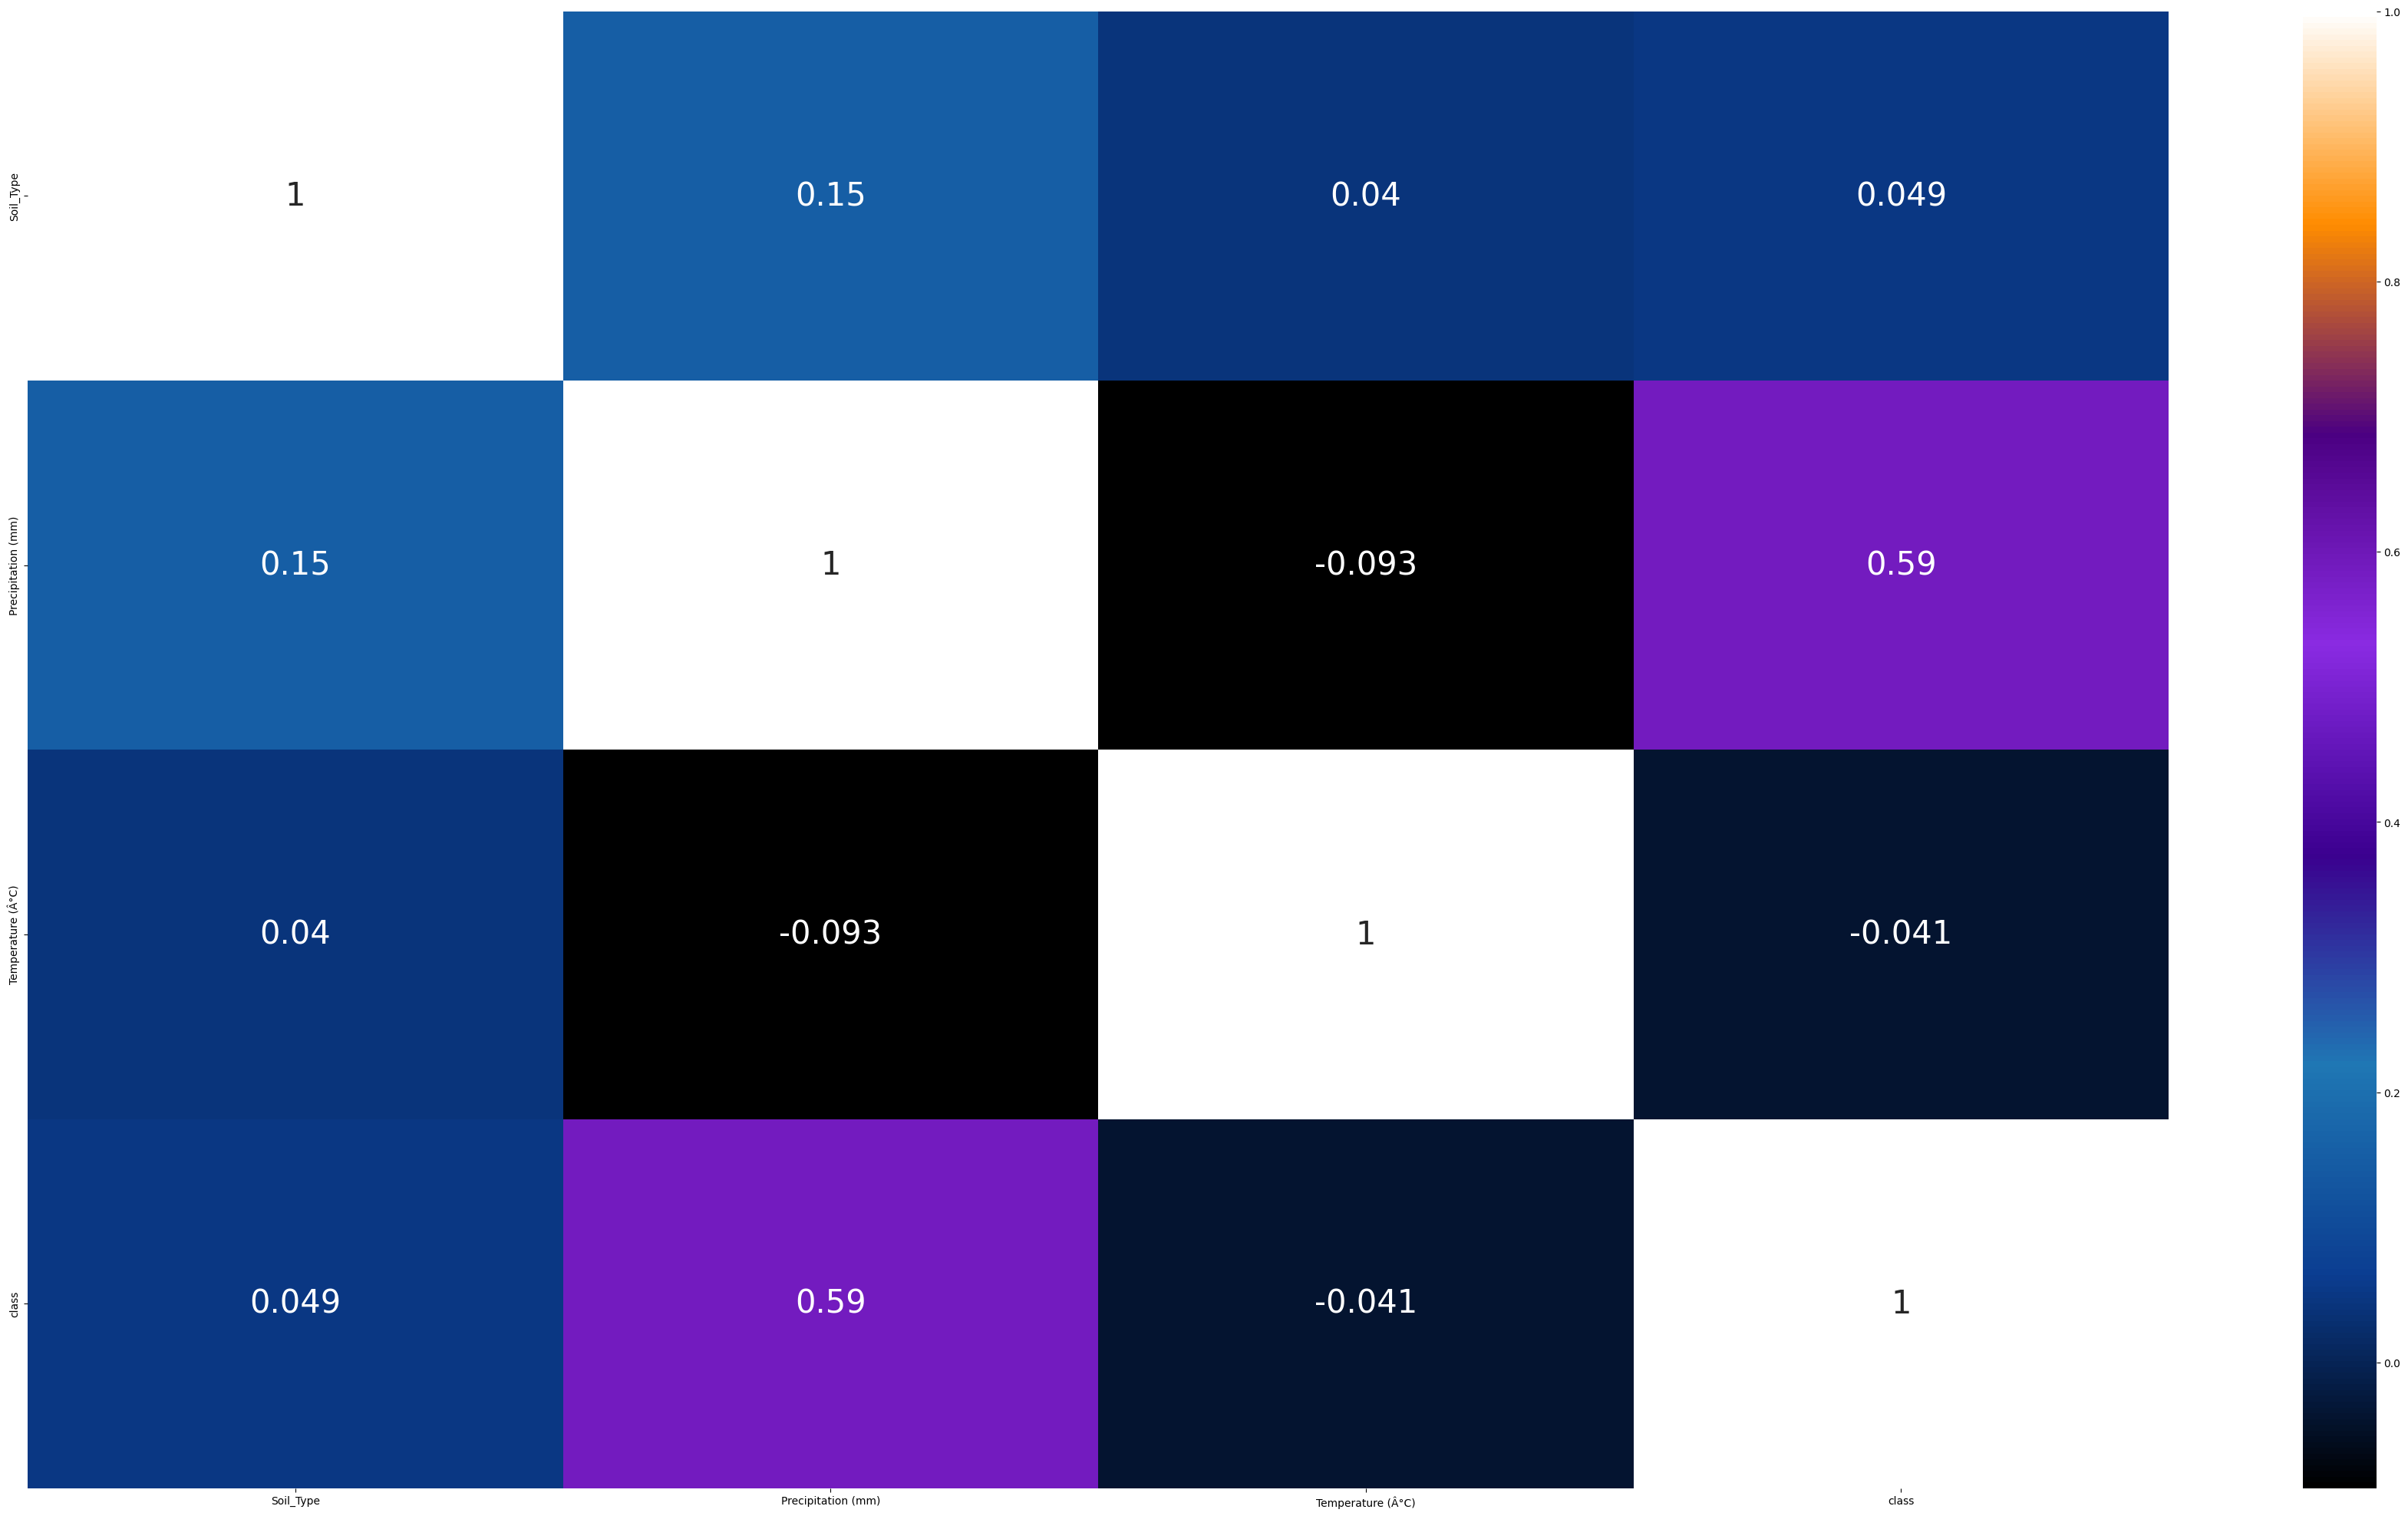

In [178]:
plt.figure(figsize=(45,25))
space_colors = ["#000000", "#0b3d91", "#1f77b4", "#3b008f", "#8a2be2", "#4b0082", "#ff8c00", "#ffffff"]
space_cmap = LinearSegmentedColormap.from_list("space_cmap", space_colors)
sns.heatmap(correlation_matrix,annot = True,cmap=space_cmap,annot_kws={"size":30})
plt.show()

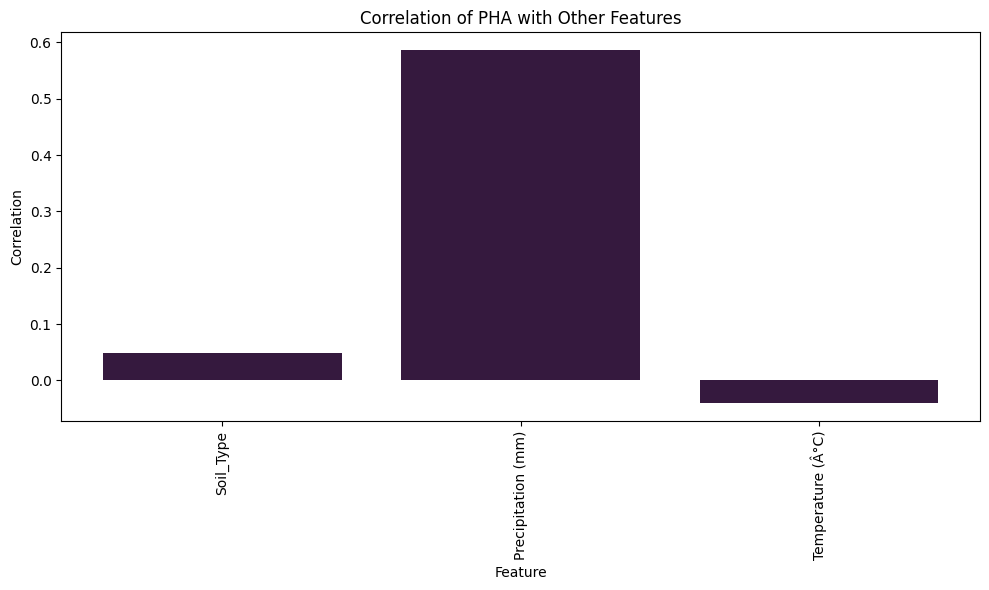

In [179]:
correlation_dict = {}
for col in updated_crops.drop(columns=['class']).columns:
  correlation_dict[col] = updated_crops['class'].corr(updated_crops[col])
correlation_values = list(correlation_dict.values())
column_names = list(correlation_dict.keys())
plt.figure(figsize=(10, 6))
plt.bar(column_names, correlation_values)
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation of PHA with Other Features')
plt.xticks(rotation=90)
plt.tight_layout()

## Training and Testing Model

In [180]:
test_size = int(0.3*(updated_crops.shape[0]))
test_data = updated_crops.sample(test_size,random_state=42)
updated_crops.drop(test_data.index,inplace=True)

In [181]:
Xtest = test_data.drop(columns=["class"],axis=1)
ytest = test_data['class']

balancing imbalanced data by undersampling

In [182]:
x = updated_crops.drop(columns=["class"],axis=1)
y = updated_crops["class"]
ros = RandomOverSampler(random_state = 42)
X_resampled,y_resampled = ros.fit_resample(x,y)

Balanced data

In [183]:
print(y.value_counts())
print(y_resampled.value_counts())

class
3    22
6    20
1    19
7    17
0    13
2     7
5     5
4     2
Name: count, dtype: int64
class
5    22
0    22
3    22
7    22
6    22
1    22
2    22
4    22
Name: count, dtype: int64


In [184]:
print(X_resampled.shape)
print(y_resampled.shape)

(176, 3)
(176,)


In [185]:
kf=KFold(n_splits=15,random_state=42,shuffle=True)
Accuracy,All_prec,All_rec,test_recall,test_accuracy,test_precision = {},{},{},{},{},{}

### RANDOM FOREST CLASSIFIER 

In [186]:
rfc = RandomForestClassifier() 

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,train_size=0.7,random_state=42)
rfc.fit(X_train,y_train)
y_pred= rfc.predict(X_test)
print(f'Accuracy:{accuracy_score(y_test,y_pred)*100:.4f}%')

Accuracy:100.0000%


In [188]:
y_pred = rfc.predict(Xtest)
print(f'Unseen Data Accuracy:{accuracy_score(ytest,y_pred)*100:.4f}%')

Unseen Data Accuracy:95.5556%


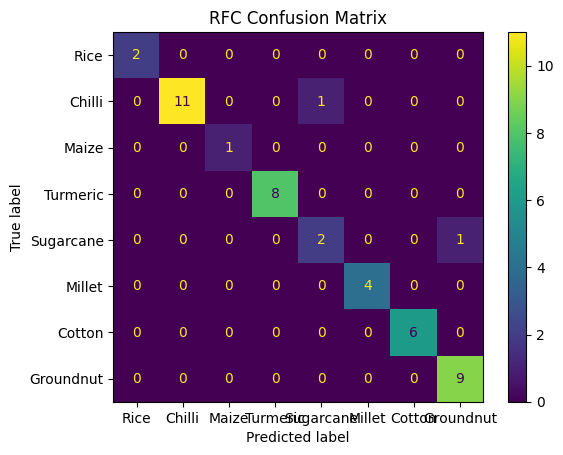

In [189]:
confusion_mat = confusion_matrix(ytest,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = classes)
cm_display.plot()
plt.title("RFC Confusion Matrix")
plt.show()

In [190]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.92      0.96        12
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         8
           4       0.67      0.67      0.67         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         6
           7       0.90      1.00      0.95         9

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



In [191]:
param_dist = {
    'n_estimators': [10, 50],
    'max_depth':[3, 5, 10, 15],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

In [192]:
random_search = RandomizedSearchCV(estimator=rfc,param_distributions=param_dist,scoring="accuracy",cv=10)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [3, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [10, 50]},
                   scoring='accuracy')

In [193]:

best_params = random_search.best_params_
max_depth = best_params['max_depth']
n_estimators = best_params['n_estimators']
min_sample_split = best_params['min_samples_split']
min_sample_leaf = best_params['min_samples_leaf']
best_params

{'n_estimators': 50,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 3}

In [194]:
best_rfc=RandomForestClassifier(n_estimators=n_estimators,min_samples_split=min_sample_split, min_samples_leaf=min_sample_leaf,max_depth=max_depth)

In [195]:
scores=[]
precision= []
recall=[]
for train_index, test_index in kf.split(X_resampled,y_resampled):
  X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
  y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
  best_rfc.fit(X_train, y_train)
  y_pred=best_rfc.predict(X_test)
  prec = precision_score(y_test,y_pred,average = 'macro')
  rec = recall_score(y_test,y_pred,average = 'macro')
  score = accuracy_score(y_test,y_pred)
  precision.append(prec)
  scores.append(score)
  recall.append(rec)
  print(f'Fold Score: {score}')

Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 0.9166666666666666
Fold Score: 0.9166666666666666
Fold Score: 1.0
Fold Score: 0.9166666666666666
Fold Score: 0.8333333333333334
Fold Score: 1.0
Fold Score: 0.9166666666666666
Fold Score: 1.0
Fold Score: 0.9090909090909091
Fold Score: 0.9090909090909091
Fold Score: 1.0
Fold Score: 0.7272727272727273


In [196]:
average_score = sum(scores) / len(scores)
average_precision = sum(precision)/len(precision)
average_recall = sum(recall)/len(recall)
Accuracy['Random Forest'] = average_score
All_prec['Random Forest'] = average_precision
All_rec['Random Forest'] = average_recall
print(f'Average Cross-Validation Score: {average_score*100:.4f}')
print(f'Average Precision score: {average_precision*100:.4f}')
print(f'Average Recall score: {average_recall*100:.4f}')

Average Cross-Validation Score: 93.6364
Average Precision score: 93.4101
Average Recall score: 92.9074


In [197]:
y_pred=best_rfc.predict(Xtest)
test_accuracy['Random Forest'] = accuracy_score(ytest,y_pred)
test_precision['Random Forest'] = precision_score(ytest,y_pred,average="macro")
test_recall['Random Forest'] = recall_score(ytest,y_pred,average="macro")

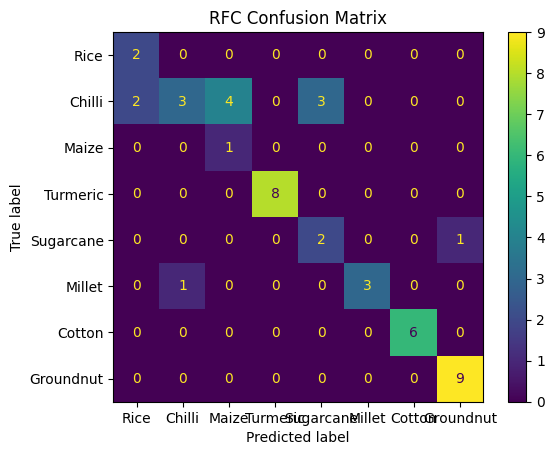

In [198]:
confusion_mat=confusion_matrix(ytest,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = classes)
cm_display.plot()
plt.title('RFC Confusion Matrix')
plt.show()

In [199]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.75      0.25      0.38        12
           2       0.20      1.00      0.33         1
           3       1.00      1.00      1.00         8
           4       0.40      0.67      0.50         3
           5       1.00      0.75      0.86         4
           6       1.00      1.00      1.00         6
           7       0.90      1.00      0.95         9

    accuracy                           0.76        45
   macro avg       0.72      0.83      0.71        45
weighted avg       0.83      0.76      0.75        45



### XGB CLASSIFIER (Approx. Training time ~2.5 Hrs)

In [200]:
xgb_model = XGBClassifier()

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,test_size=0.3,random_state=42)
xgb_model.fit(X_train,y_train)
y_pred= xgb_model.predict(X_test)
print(f'Accuracy:{accuracy_score(y_test,y_pred)*100:.4f}%')

Accuracy:100.0000%


In [202]:
y_pred = xgb_model.predict(Xtest)
print(f'Unseen Data Accuracy:{accuracy_score(ytest,y_pred)*100:.4f}%')

Unseen Data Accuracy:97.7778%


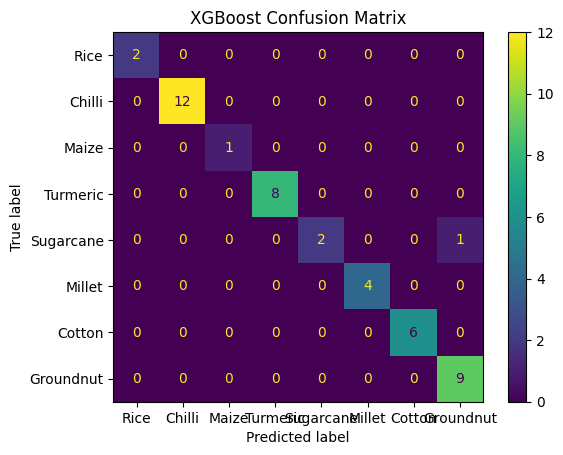

In [203]:

confusion_mat = confusion_matrix(ytest,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = classes)
cm_display.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

In [204]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         8
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         6
           7       0.90      1.00      0.95         9

    accuracy                           0.98        45
   macro avg       0.99      0.96      0.97        45
weighted avg       0.98      0.98      0.98        45



In [205]:
param_dist = {
    'learning_rate': [0.001,0.01],
    'n_estimators': [10, 100],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1],
    'reg_lambda':[1,10],
    'reg_alpha':[0.01,0.05]
}

In [206]:
random_search = RandomizedSearchCV(estimator=xgb_model,param_distributions=param_dist,scoring="accuracy",cv=5)
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='multi:softprob', ...),
                   param_distributions={'gamma': [0, 0.1],
                                        'learning_rate': [0.001, 0.01],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [10, 100],
                                        'reg_alpha': [0.01, 0.05],
                                        'reg_lambda': [1, 10]},
                   scoring='accuracy')

In [207]:
best_params = random_search.best_params_
learning_rate = best_params['learning_rate']
n_estimators = best_params['n_estimators']
min_child_weight = best_params['min_child_weight']
gamma = best_params['gamma']
reg_lambda = best_params['reg_lambda']
reg_alpha = best_params['reg_alpha']

In [208]:
best_xgb=XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators,min_child_weight=min_child_weight,max_depth=max_depth,gamma=gamma,reg_alpha=reg_alpha,reg_lambda=reg_lambda)

In [209]:
scores=[]
precision = []
recall = []
for train_index, test_index in kf.split(X_resampled,y_resampled):
  X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
  y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
  best_xgb.fit(X_train, y_train)
  y_pred = best_xgb.predict(X_test)
  score = accuracy_score(y_test,y_pred)
  prec = precision_score(y_test,y_pred,average="macro")
  rec = recall_score(y_test,y_pred,average="macro")
  scores.append(score)
  precision.append(prec)
  recall.append(rec)
  print(f'Fold Score: {score}')

Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0
Fold Score: 1.0


In [210]:
average_score = sum(scores) / len(scores)
average_precision = sum(precision)/len(precision)
average_recall = sum(recall)/len(recall)
Accuracy['XGBoost'] = average_score
All_prec['XGBoost'] = average_precision
All_rec['XGBoost'] = average_recall
print(f'Average Cross-Validation Score: {average_score*100:.4f}')
print(f'Average Precision score: {average_precision*100:.4f}')
print(f'Average Recall score: {average_recall*100:.4f}')

Average Cross-Validation Score: 100.0000
Average Precision score: 100.0000
Average Recall score: 100.0000


In [211]:
y_pred = best_xgb.predict(Xtest)
test_accuracy['XGBoost'] = accuracy_score(ytest,y_pred)
test_precision['XGBoost'] = precision_score(ytest,y_pred,average="macro")
test_recall['XGBoost'] = recall_score(ytest,y_pred,average="macro")

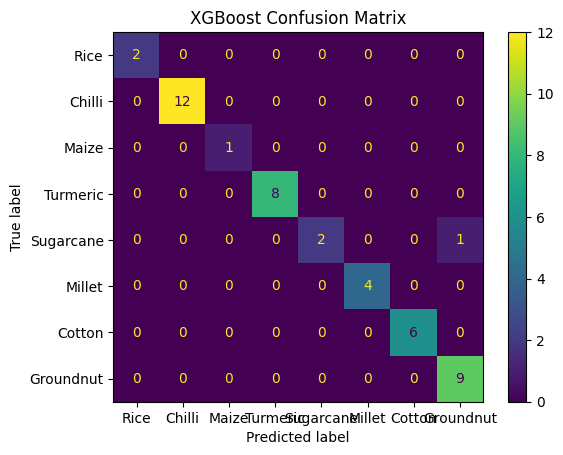

In [212]:
confusion_mat=confusion_matrix(y_pred=y_pred,y_true=ytest)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = classes)
cm_display.plot()
plt.title('XGBoost Confusion Matrix')
plt.show()

In [213]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         8
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         6
           7       0.90      1.00      0.95         9

    accuracy                           0.98        45
   macro avg       0.99      0.96      0.97        45
weighted avg       0.98      0.98      0.98        45



### LOGISTIC REGRESSION (Approx. Training Time ~5 Mins)

In [214]:
lr = LogisticRegression()

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,test_size=0.3,random_state=42)
lr.fit(X_train,y_train)
y_pred= lr.predict(X_test)
print(f'Accuracy:{accuracy_score(y_test,y_pred)*100:.4f}%')

Accuracy:79.2453%


In [216]:
y_pred = lr.predict(Xtest)
print(f'Unseen Data Accuracy:{accuracy_score(ytest,y_pred)*100:.4f}%')

Unseen Data Accuracy:48.8889%


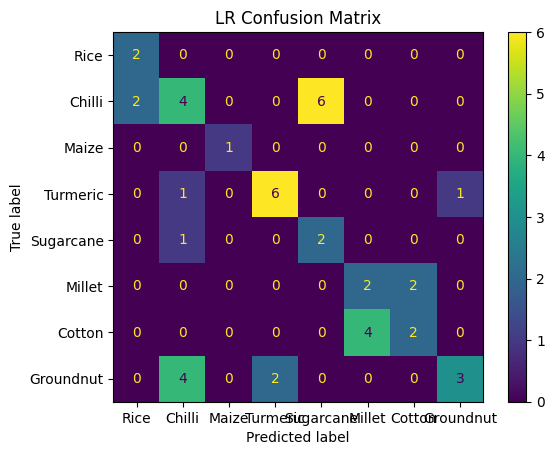

In [217]:
confusion_mat = confusion_matrix(ytest,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = classes)
cm_display.plot()
plt.title("LR Confusion Matrix")
plt.show()

In [218]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.40      0.33      0.36        12
           2       1.00      1.00      1.00         1
           3       0.75      0.75      0.75         8
           4       0.25      0.67      0.36         3
           5       0.33      0.50      0.40         4
           6       0.50      0.33      0.40         6
           7       0.75      0.33      0.46         9

    accuracy                           0.49        45
   macro avg       0.56      0.61      0.55        45
weighted avg       0.55      0.49      0.49        45



In [219]:
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

In [220]:
grid_search = RandomizedSearchCV(estimator=lr,param_distributions=param_dist,scoring='accuracy',cv=10)
grid_search.fit(X_train,y_train)

RandomizedSearchCV(cv=10, estimator=LogisticRegression(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'solver': ['liblinear', 'lbfgs']},
                   scoring='accuracy')

In [221]:
best_params = grid_search.best_params_
C = best_params['C']
Solver = best_params['solver']
best_lr = LogisticRegression(C=C,solver=Solver)

In [222]:
scores=[]
precision =[]
recall = []
for train_index, test_index in kf.split(X_resampled,y_resampled):
  X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
  y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
  best_lr.fit(X_train, y_train)
  y_pred=best_lr.predict(X_test)
  prec = precision_score(y_test,y_pred,average="macro")
  rec = recall_score(y_test,y_pred,average='macro')
  score = best_lr.score(X_test, y_test)
  scores.append(score)
  precision.append(prec)
  recall.append(rec)
  print(f'Fold Score: {score}')

Fold Score: 0.8333333333333334
Fold Score: 1.0
Fold Score: 0.9166666666666666
Fold Score: 0.9166666666666666
Fold Score: 0.9166666666666666
Fold Score: 1.0
Fold Score: 0.8333333333333334
Fold Score: 0.75
Fold Score: 1.0
Fold Score: 0.9166666666666666
Fold Score: 0.9166666666666666
Fold Score: 0.9090909090909091
Fold Score: 0.8181818181818182
Fold Score: 1.0
Fold Score: 0.5454545454545454


In [223]:
average_score = sum(scores) / len(scores)
average_precision = sum(precision)/len(precision)
average_recall = sum(recall)/len(recall)
Accuracy['Logistic Regression'] = average_score
All_prec['Logistic Regression'] = average_precision
All_rec['Logistic Regression '] = average_recall
print(f'Average Cross-Validation Score: {average_score*100:.4f}')
print(f'Average Precision score: {average_precision*100:.4f}')
print(f'Average Recall score: {average_recall*100:.4f}')

Average Cross-Validation Score: 88.4848
Average Precision score: 83.7831
Average Recall score: 83.4788


In [224]:
y_pred= best_lr.predict(Xtest)
test_accuracy['Logistic Regression'] = accuracy_score(ytest,y_pred)
test_recall['Logistic Regression'] = recall_score(ytest,y_pred,average="macro")
test_precision['Logistic Regression'] = precision_score(ytest,y_pred,average="macro")

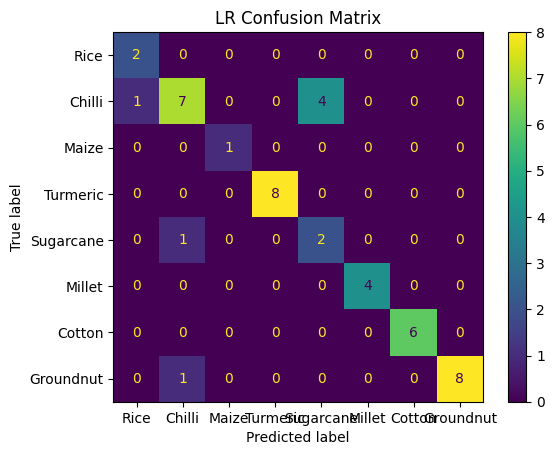

In [225]:
confusion_mat=confusion_matrix(y_pred=y_pred,y_true=ytest)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = classes)
cm_display.plot()
plt.title('LR Confusion Matrix')
plt.show()

In [226]:
print(classification_report(y_pred=y_pred,y_true=ytest))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.78      0.58      0.67        12
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         8
           4       0.33      0.67      0.44         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         6
           7       1.00      0.89      0.94         9

    accuracy                           0.84        45
   macro avg       0.85      0.89      0.86        45
weighted avg       0.88      0.84      0.85        45



In [227]:
model_name = [key for key in Accuracy.keys()]
model_accuracy = [acc for acc in Accuracy.values()]
model_precision = [prec for prec in All_prec.values()]
model_recall = [rec for rec in All_rec.values()]
model_data = pd.DataFrame([model_accuracy,model_precision,model_recall],index=['Accuracy','Precision','Recall'],columns=model_name)
model_data

,Random Forest,XGBoost,Logistic Regression
Accuracy,0.936364,1.0,0.884848
Precision,0.934101,1.0,0.837831
Recall,0.929074,1.0,0.834788


**XGBoost Overall Provides better Accuracy and Precision. Hence, will be the selected model for the time-being to classify the crops.**